<a href="https://colab.research.google.com/github/donw7/neural_activity_models_DNNs/blob/main/neural-sequence_transformers_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# testing transformers on neural activity sequences
- motivation:
  - neuroscience lacks ways of flexibly modeling both global and local modulation of neural activity, lacks accucracy on real-time, and models are computationally inefficient e.g. for BCI applications
  - ML research on sequence models would benefit from extension of transformer architecture into other domains, testing of its embeddings to capture meaningful features of neural activity, as proof-of-concept for a generalized architecture
- framework:
  - neural activity may be construed as a sequence analogous to a text sequence
  - will first utilize data structure from language sentiment classification analysis to test training implementation. Then, will convert and reformat data structure of neural activity to resemble that of language data. Time bins for neural activity spikes can be analogous to tokenized vocab. Then will train analogously to model behavioral decisions in mice (further explanation of decision-making task below)
- applications:
  - interbrain and intrabrain functional connectivity can thus be viewed as machine translation applications
  - brain-behavior relationships as classification
  - real-time anomaly detection, e.g. epileptiform activity
- hypotheses: 
  - transformers will outperform traditional models for neural activity 
  - transformers will be more efficient, potentially more useful for embedded devices and higher-order network modeling

- outline: 
  - load data: text, neural
  - data exploration: text, neural
  - test train on text data
  - reformat neural data
  - modify transformer functions for neural
  - test train on neural data

## load dependencies

In [ ]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install pytorch_pretrained_bert --quiet

In [ ]:
import numpy as np
import pandas as pd
import math
import statistics
from typing import Tuple

import torch
import torch.nn.functional as F
# import torchtext
from torch import nn, Tensor
from torch.utils.data import dataset # note pytorch object referred to as dataset whereas huggingface as datasets

# transformers library from HuggingFace
from transformers import Trainer
from transformers import pipeline
from transformers import set_seed
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM
from transformers import AutoModelForSequenceClassification

# metrics
from datasets import load_metric
from datasets import load_dataset

# interactive dataframe object
#from google.colab import data_table
#data_table.enable_dataframe_formatter()

# plotly & other tools
#import plotly.express as px
#import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from pprint import pprint
import requests, tarfile, os
 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print('test')

## set up transformer class and helper functions

In [ ]:
class TransformerSentiment(nn.Module):
  """Transformer Encoder network for classification

    Args:
      k (int): Attention embedding size
      heads (int): Number of self attention heads
      depth (int): How many transformer blocks to include
      seq_length (int): How long an input sequence is
      num_tokens (int): Size of dictionary
      num_classes (int): Number of output classes
  """
  def __init__(self, k, heads, depth, seq_length, num_tokens, num_classes):
    super().__init__()

    self.k = k
    self.num_tokens = num_tokens
    self.token_embedding = nn.Embedding(num_tokens, k)
    self.pos_enc = PositionalEncoding(k)

    transformer_blocks = []
    for i in range(depth):
      transformer_blocks.append(TransformerBlock(k=k, heads=heads))

    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.classification_head = nn.Linear(k, num_classes)

  def forward(self, x):
    """Forward pass for Classification Transformer network

    Args:
      x (torch.Tensor): (b, t) sized tensor of tokenized words

    Returns:
      torch.Tensor of size (b, c) with log-probabilities over classes
    """
    x = self.token_embedding(x) * np.sqrt(self.k)
    x = self.pos_enc(x)
    x = self.transformer_blocks(x)

    # mean pooling
    sequence_avg = x.mean(dim=1)
    x = self.classification_head(sequence_avg)
    logprobs = F.log_softmax(x, dim=1)

    return logprobs

In [ ]:
class TransformerBlock(nn.Module):
  """Transformer Block
  Args:
    k (int): Attention embedding size
    heads (int): number of self-attention heads

  Attributes:
    attention: Multi-head SelfAttention layer
    norm_1, norm_2: LayerNorms
    mlp: feedforward neural network
  """
  def __init__(self, k, heads):
    super().__init__()

    #print()
    self.attention = SelfAttention(k, heads=heads)

    self.norm_1 = nn.LayerNorm(k)
    self.norm_2 = nn.LayerNorm(k)

    hidden_size = 2 * k  
    self.mlp = nn.Sequential(
        nn.Linear(k, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, k))

  def forward(self, x):
    attended = self.attention(x)

    # Add & Normalize layer
    x = self.norm_1(attended + x)
    feedforward = self.mlp(x)
    
    # second Add & Normalize layer
    x = self.norm_2(feedforward + x)

    return x

In [ ]:
class SelfAttention(nn.Module):
  """Multi-head self attention layer

  Args:
    k (int): Size of attention embeddings
    heads (int): Number of attention heads

  Attributes:
    to_keys: Transforms input to k x k*heads key vectors
    to_queries: Transforms input to k x k*heads query vectors
    to_values: Transforms input to k x k*heads value vectors
    unify_heads: combines queries, keys and values to a single vector
  """
  def __init__(self, k, heads=8, dropout=0.2): # change from 0.1
    super().__init__()
    self.k, self.heads = k, heads

    self.to_keys = nn.Linear(k, k * heads, bias=False)
    self.to_queries = nn.Linear(k, k * heads, bias=False)
    self.to_values = nn.Linear(k, k * heads, bias=False)
    self.unify_heads = nn.Linear(k * heads, k)

    self.attention = DotProductAttention(dropout)

  def forward(self, x):
    """Implements forward pass of self-attention layer
    Args:
      x (torch.Tensor): batch x t x k sized input
    """
    #print(f"input into forward of SelfAttention: {x.size()}") # debug

    b, t, k = x.size()
    h = self.heads

    # reshape the queries, keys and values so that each head has its own dimension
    queries = self.to_queries(x).view(b, t, h, k)
    keys = self.to_keys(x).view(b, t, h, k)
    values = self.to_values(x).view(b, t, h, k)

    out = self.attention(queries, keys, values, b, h, t, k)

    return self.unify_heads(out)

In [ ]:
class DotProductAttention(nn.Module):
  """Scaled dot product attention."""
  def __init__(self, dropout, **kwargs):
    super(DotProductAttention, self).__init__(**kwargs)
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, b, h, t, k):
    """
    Compute dot products. This is the same operation for each head,
    so we can fold the heads into the batch dimension and use torch.bmm
    Note: .contiguous() doesn't change the actual shape of the data,
    but it rearranges the tensor in memory, which will help speed up the computation
    for this batch matrix multiplication.
    .transpose() is used to change the shape of a tensor. It returns a new tensor
    that shares the data with the original tensor. It can only swap two dimension.

    Shape of `queries`: (`batch_size`, no. of queries, head,`k`)
    Shape of `keys`: (`batch_size`, no. of key-value pairs, head, `k`)
    Shape of `values`: (`batch_size`, no. of key-value pairs, head, value dimension)

    b: batch size
    h: number of heads
    t: number of keys/queries/values (for simplicity, let's assume they have the same sizes)
    k: embedding size
    """
    keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
    queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
    values = values.transpose(1, 2).contiguous().view(b * h, t, k)

    # Matrix Multiplication between the keys and queries
    score = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(k)  # size: (b * h, t, t)
    softmax_weights = F.softmax(score, dim=2)  # row-wise normalization of weights

    # Matrix Multiplication between the output of the key and queries multiplication and values.
    out = torch.bmm(self.dropout(softmax_weights), values).view(b, h, t, k)  # rearrange h and t dims
    out = out.transpose(1, 2).contiguous().view(b, t, h * k)

    return out

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


### train function

In [ ]:
def train(model, loss_fn, train_loader,
          n_iter=1, learning_rate=1e-4,
          test_loader=None, device='cpu',
          L2_penalty=0, L1_penalty=0):
  """Run gradient descent to opimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data
    n_iter (int, optional): number of iterations of gradient descent to run
    learning_rate (float, optional): learning rate to use for gradient descent
    test_data (torch.Tensor, optional): n_test x n_neurons tensor with neural
      responses to test on
    test_labels (torch.Tensor, optional): n_test x 1 tensor with orientations of
      the stimuli corresponding to each row of test_data
    L2_penalty (float, optional): l2 penalty regularizer coefficient
    L1_penalty (float, optional): l1 penalty regularizer coefficient

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch Adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []
  test_loss = []

  # Loop over epochs (cf. appendix)
  for iter in range(n_iter):
    iter_train_loss = []
    for i, batch in tqdm(enumerate(train_loader)):
      # compute network output from inputs in train_data

      # modified
      out = model(batch['input_ids'].to(device))
      loss = loss_fn(out, batch['label'].to(device))

      # Clear previous gradients
      optimizer.zero_grad()

      # Compute gradients
      loss.backward()

      # Update weights
      optimizer.step()

      # Store current value of loss
      iter_train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar
      if i % 50 == 0:
        print(f'[Batch {i}]: train_loss: {loss.item()}')
    train_loss.append(statistics.mean(iter_train_loss))

    # Track progress
    if True: #(iter + 1) % (n_iter // 5) == 0:

      if test_loader is not None:
        print('Running Test loop')
        iter_loss_test = []
        for j, test_batch in enumerate(test_loader):

          out_test = model(test_batch['input_ids'].to(device))
          loss_test = loss_fn(out_test, test_batch['label'].to(device))
          iter_loss_test.append(loss_test.item())

        test_loss.append(statistics.mean(iter_loss_test))

      if test_loader is None:
        print(f'iteration {iter + 1}/{n_iter} | train loss: {loss.item():.3f}')
      else:
        print(f'iteration {iter + 1}/{n_iter} | train loss: {loss.item():.3f} | test_loss: {loss_test.item():.3f}')

  if test_loader is None:
    return train_loss
  else:
    return train_loss, test_loss



### load data function

In [ ]:
def load_yelp_data(DS, tokenizer):
  dataset = DS # from huggingface object?
  dataset['train'] = dataset['train'].select(range(10000)) # hardcoded selection
  dataset['test'] = dataset['test'].select(range(5000))
  dataset = dataset.map(lambda e: tokenizer(e['text'], truncation=True,
                                            padding='max_length'), batched=True) # tokenize
  print(f"dataset after tokenization, 'input_ids': {dataset['train']['input_ids'][0]}")
  print(f"type: {type(dataset['train']['input_ids'][0])}")
  
  dataset.set_format(type='torch', columns=['input_ids', 'label']) # set format
  print(f"dataset type after .set_format: {dataset['train']['input_ids'][0]}")
  print(f"dataset type after .set_format: {type(dataset['train']['input_ids'][0])}")

  train_loader = torch.utils.data.DataLoader(dataset['train'], batch_size=32) # hardcoded batch size
  test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=32)
  
  print(f"dataset after utils.DataLoader: {next(iter(train_loader))['input_ids']}")
  print(f"type: {type(next(iter(train_loader))['input_ids'])}")
  vocab_size = tokenizer.vocab_size
  max_len = next(iter(train_loader))['input_ids'].shape[0]
  num_classes = next(iter(train_loader))['label'].shape[0]


  return train_loader, test_loader, max_len, vocab_size, num_classes
  

## load text dataset

In [ ]:
DS = load_dataset("yelp_review_full", download_mode="reuse_dataset_if_exists")
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
DS_train_loader, DS_test_loader, max_len, vocab_size, num_classes = load_yelp_data(DS, tokenizer)
batch1 = next(iter(DS_test_loader))

In [ ]:
print(batch1)
print(batch1['label'].shape)
print(batch1['input_ids'].shape)

## load neural activity dataset

from Steinmetz et al., 2019, session "Cori_2016-12-18". See explanation below

In [ ]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1W3TwEtC0Z6Qmbfuz8_AWRiQHfuDb9FIS',
                                    dest_path='./Binned_data.zip',
                                    unzip=True)

binned_spikes = np.load('binned_spikes.npy')
choices = np.load('choices.npy')+1


In [ ]:
# 228 trials, 1089 neurons, and 50 bins per trial (for a time of 20ms per bin).
print(binned_spikes.shape, choices.shape)
print(binned_spikes.dtype, choices.dtype)

In [ ]:
print(binned_spikes[1,:,:])
print(choices[:10])

In [ ]:
# plt.eventplot(binned_spikes[1,:,:].T)

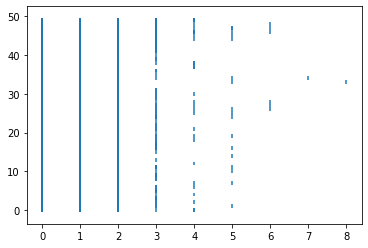

## data exploration

### text data

In [ ]:
print(DS.column_names)
print(DS.shape)
print(f"text is {type(DS_train_loader.dataset['text'])}")
print(f"label is {type(DS_train_loader.dataset['label'])}")

df_text = pd.DataFrame(DS_train_loader.dataset['text'])
df_label = pd.DataFrame(DS_train_loader.dataset['label'])
df_labeltext = pd.concat([df_label, df_text], axis=1)

# choices as first column, spikes as rest
display(df_labeltext)

### neural data

Neuropixels recordings from Steinmetz et al., 2019 of mice engaging in visual decision-making task. Will try to predict choices from 1 s of neural activity prior to choice. 

"Mice earned water rewards by turning a wheel to indicate which of two visual gratings had higher contrast, or by not turning if no stimulus was presented. When stimuli had equal contrast, a left or right choice was rewarded with 50% probability."

Paradigm: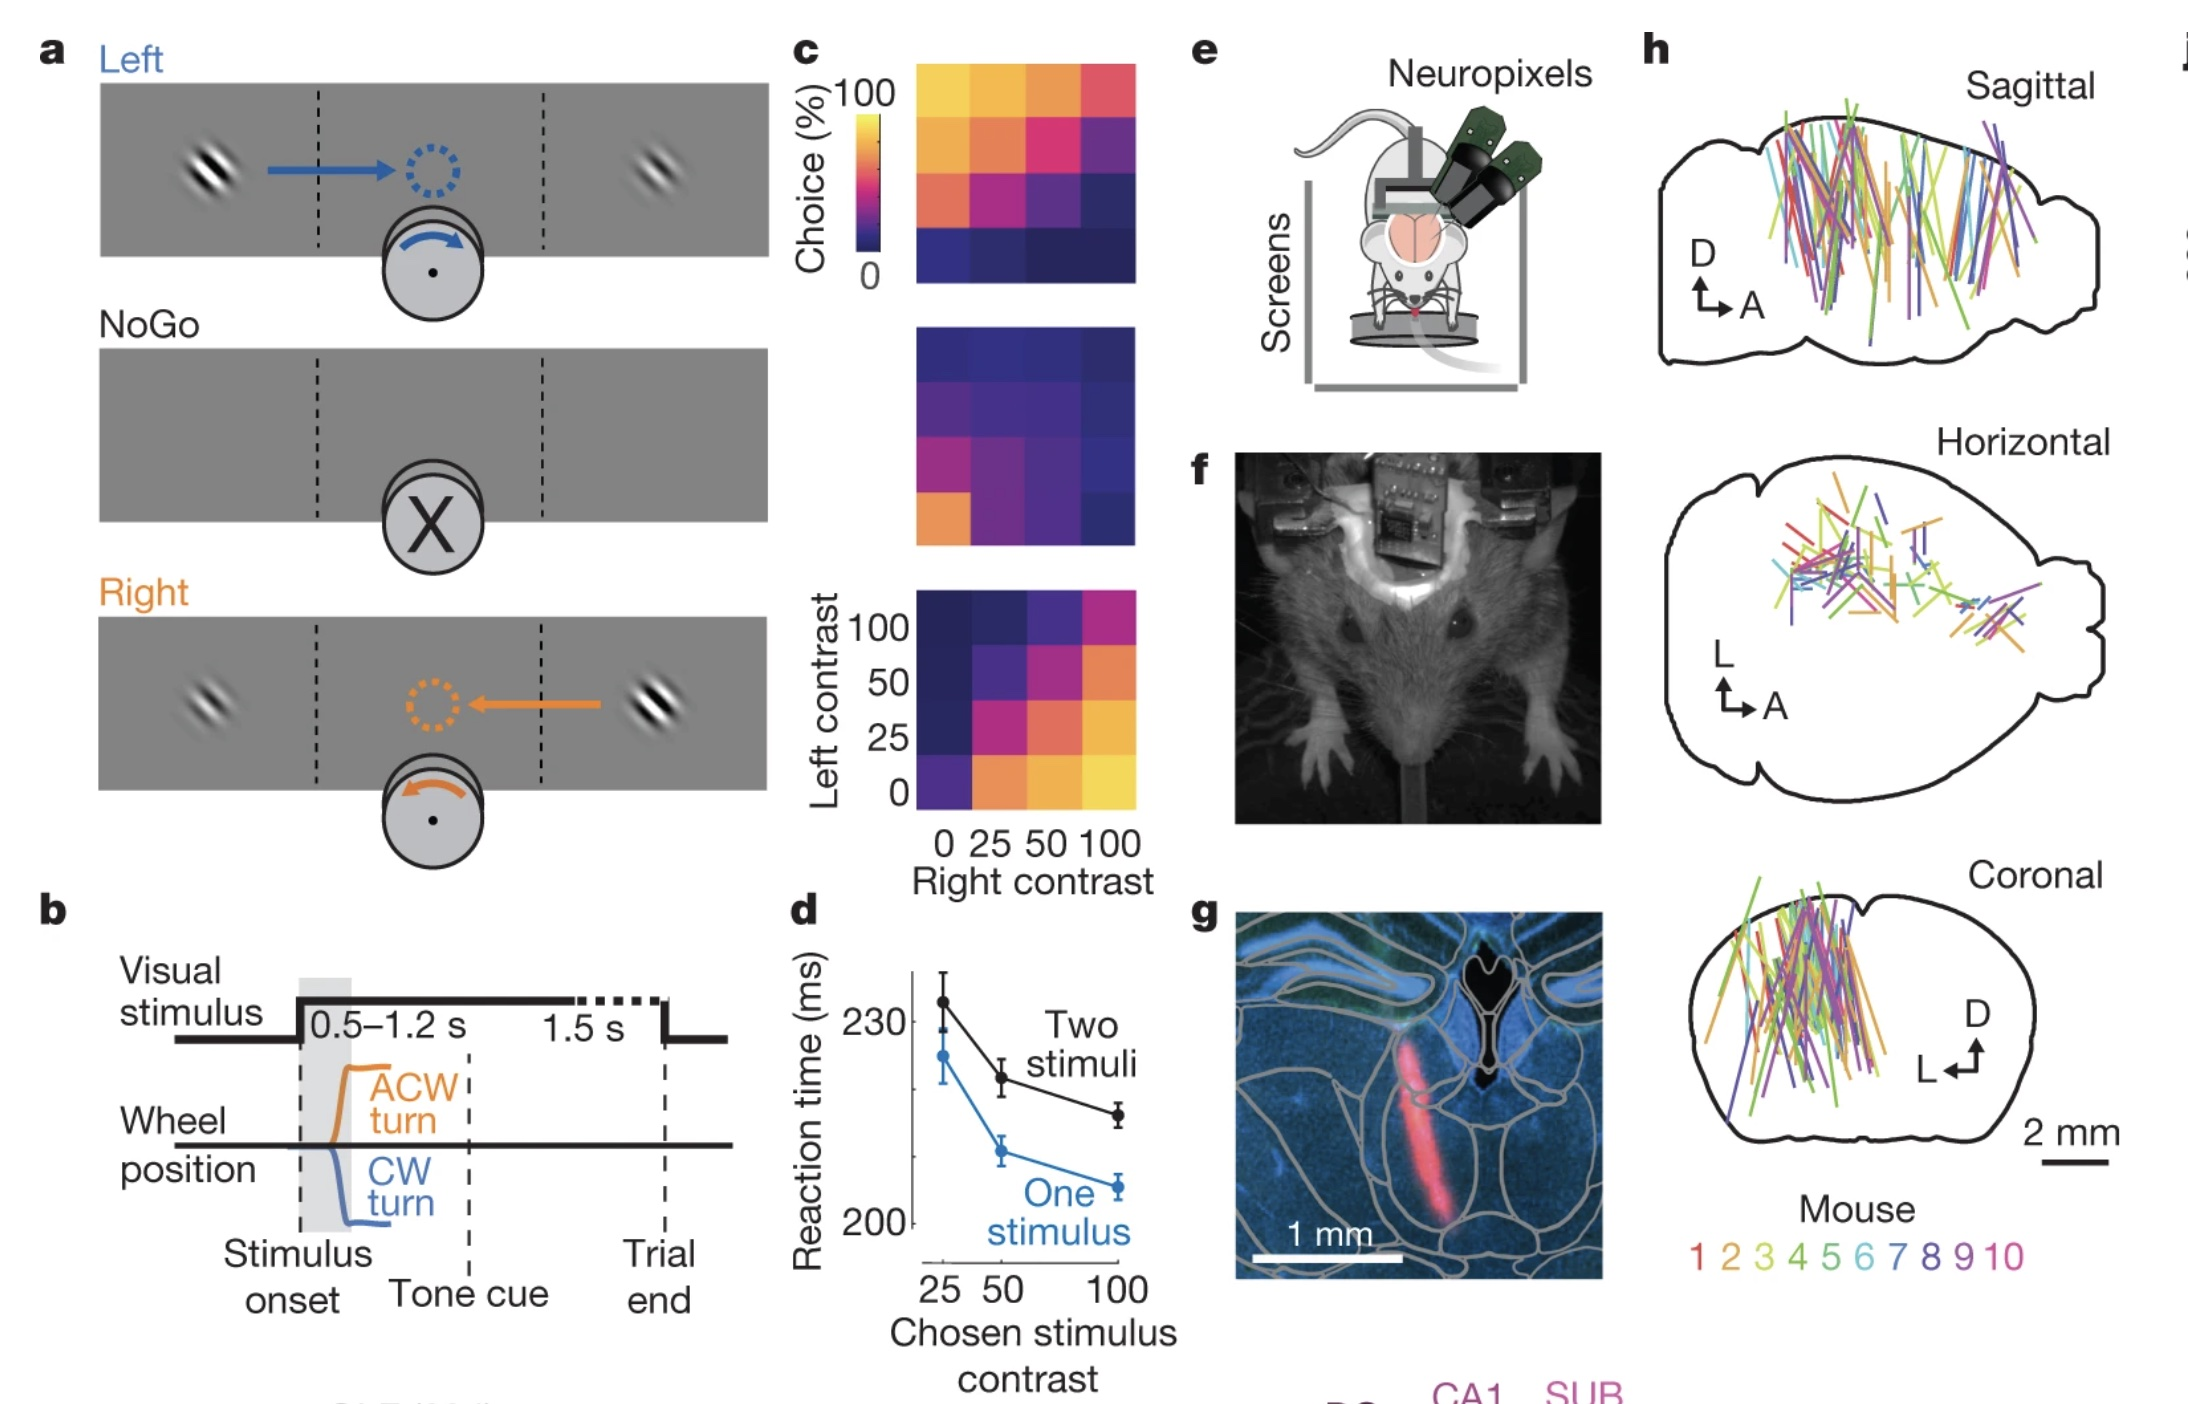

In [ ]:
# print binned spikes event plots
displayidx = range(5) # trial indices to display
for di in displayidx:
  df_spikes_trial = pd.DataFrame(binned_spikes[di,:,:].T)
  positions = df_spikes_trial.apply(lambda x: df_spikes_trial.index[x == 1])
  plt.figure(di)
  plt.eventplot(positions, linelengths=2, lineoffsets=1, colors='black')
  plt.yticks(range(positions.index.size), positions.index)
  plt.gca().invert_yaxis()
  plt.ylabel('neurons')
  plt.xlabel('time bins')
  plt.title(f'trial {di}')

In [ ]:
# print choices
for di in displayidx:
  print(f"decision, trial {di}: {choices[di]}")

In [ ]:
# sanity check
neudisplayidx = range(450, 455) # number of neurons to display

# check positions
print(f'trial {di}')
print(positions[450:455])

# print binned spikes event plots
displayidx = range(5) # trial indices to display
for di in displayidx:
  df_spikes_trial = pd.DataFrame(binned_spikes[di,neudisplayidx,:].T)
  positions = df_spikes_trial.apply(lambda x: df_spikes_trial.index[x == 1])
  plt.figure(di)
  plt.eventplot(positions, linelengths=0.75, colors='black')
  plt.yticks(range(positions.index.size), positions.index)
  plt.gca().invert_yaxis()
  plt.ylabel('neurons')
  plt.xlabel('time bins')
  plt.title(f'trial {di}')

# display neurons with another plot type
for di in displayidx: # trials
  plt.figure()
  plt.ylabel('# of spikes')
  plt.xlabel('time bins')
  plt.title(f'trial {di}')
  for ni in neudisplayidx: # neurons
    neuron = binned_spikes[di,ni,:] # all trial, 1 neurons, all time bins
    plt.plot(neuron)
  plt.legend(neudisplayidx)

In [ ]:
# histogram (last trial displayed)
fig, ax = plt.subplots(1,2)
ax[0].hist(df_spikes_trial)
ax[0].set_title('trial {di}')

ax[1].hist(df_spikes_trial, bins=np.logspace(0,2))
ax[1].set_xscale('log')
ax[1].set_title('Log bins')


Example heat map for firing rate:




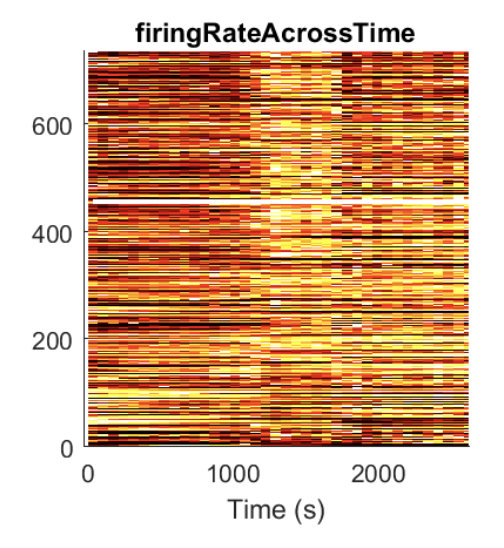

In [ ]:
data1 = np.random.random([5, 50])
print(data1)
plt.eventplot(data1)

## test train on text data

In [ ]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize network with embedding size 128, 8 attention heads, and 3 layers
model = TransformerSentiment(128, 8, 3, max_len, vocab_size, num_classes).to(device)

# Initialize built-in PyTorch Negative Log Likelihood loss function
loss_fn = F.nll_loss

train_loss, test_loss = train(model,
                              loss_fn,
                              DS_train_loader,
                              n_iter = 3,
                              test_loader=DS_test_loader,
                              device=device)

In [ ]:
print(pd.concat([pd.DataFrame(train_loss), pd.DataFrame(test_loss)], axis=1))

### plot training, test loss

In [ ]:
epochs = range(len(train_loss))
plt.plot(epochs, train_loss)
plt.plot(epochs, test_loss)

### test predictions

In [ ]:
# set idx up to batch size (e.g. 32)
# from dataset
idx = 20
pred_text = DS['test']['text'][idx]
actual_label = DS['test']['label'][idx]
print(pred_text)
print(actual_label)

In [ ]:
# predict with trained model
with torch.no_grad():
  # Batch 1 contains all the tokenized text for the 1st batch of the test loader
  pred_batch = model(batch1['input_ids'].to(device))
  # Predicting the label for the text
  print("The yelp review is → " + str(pred_text))
  predicted_label = np.argmax(pred_batch[idx].cpu())
  print("The Predicted Rating is → " + str(predicted_label) + " and the Actual Rating was → " + str(actual_label))

In [ ]:
pred_batch

In [ ]:
batch1['input_ids'][0].shape

## test load & train on neural activity data

potential issues to consider:
- tokenization & vectorization?
- embedding needed?
- can spikes be represented simply as a "dictionary" of e.g. 1-5 conditional probabilities?

### modify transformer functions

In [ ]:
class TransformerNeural(nn.Module):
  """Transformer Encoder network for classification

    Args:
      k (int): Attention embedding size
      heads (int): Number of self attention heads
      depth (int): How many transformer blocks to include
      seq_length (int): How long an input sequence is
      num_tokens (int): Size of dictionary
      num_classes (int): Number of output classes
  """
  def __init__(self, k, heads, depth, seq_length, num_tokens, num_classes):
    super().__init__()

    self.k = k
    self.num_tokens = num_tokens
    self.token_embedding = nn.Embedding(num_tokens, k)
    #self.pos_enc = PositionalEncoding(k)

    # create architecture with transformer_blocks
    transformer_blocks = []
    for i in range(depth):
      transformer_blocks.append(TransformerBlock(k=k, heads=heads))

    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.classification_head = nn.Linear(k, num_classes)

  def forward(self, x):
    """Forward pass for Classification Transformer network

    Args:
      x (torch.Tensor): (b, t) sized tensor of tokenized words

    Returns:
      torch.Tensor of size (b, c) with log-probabilities over classes
    """

    # in lieu of embedding, can try:  # x is 1x55000 or reshape x to be 1100x50

    x = self.token_embedding(x) * np.sqrt(self.k)
    
    #x = self.pos_enc(x)
    x = self.transformer_blocks(x)

    # mean pooling
    sequence_avg = x.mean(dim=1)
    x = self.classification_head(sequence_avg)
    logprobs = F.log_softmax(x, dim=1)

    return logprobs

### load neural data function

In [ ]:
def load_neural_data(nDS): #, tokenizer):
  # change to tensor long
  format = {'type': 'torch', 'format_kwargs' :{'dtype': torch.long}}
  
  nDS.set_format(**format, columns=['input_ids', 'label']) # set format
  

  train_loader = torch.utils.data.DataLoader(nDS['train'], batch_size=32) # hardcoded batch size
  test_loader = torch.utils.data.DataLoader(nDS['test'], batch_size=32)

  # vocab_size = tokenizer.vocab_size
  max_len = next(iter(train_loader))['input_ids'].shape[0]
  num_classes = next(iter(train_loader))['label'].shape[0]

  return train_loader, test_loader, max_len, num_classes #, vocab_size
  

### reformat neural data

#### import from huggingface

In [ ]:
# ?load_dataset # from hugging face?
# ?train_loader # from utils
from datasets import Dataset # huggingface

In [ ]:
# the text dataset looks like: dataset['train'][0]: {'label': 0, 'text': [222, 8246, 6363, ..., number_of_words_in_sentence_eg_50]}
# nDS['train'][0]: {'label': 0, 'text': [[1, 1, 0, 2, 3,..., 1100], [2, 0, 0, 1, 1, ...], ..., 50]}

In [ ]:
# spikes data looks like:
np.unique(binned_spikes)

In [ ]:
# convert to tensor and load into pd
column_names = ["label", "input_ids"]
nDS_train_df = pd.DataFrame(columns = column_names)

#### memory management

In [57]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    
    

from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

!nvidia-smi
# %reset

                 binned_spikes: 94.7 MiB
                  df_labeltext:  7.4 MiB
                       df_text:  7.4 MiB
                      df_label: 78.3 KiB
                  nDS_train_df: 33.5 KiB
                   nDS_test_df:  7.3 KiB
                           _i9:  2.9 KiB
               df_spikes_trial:  2.1 KiB
                         data1:  2.1 KiB
                          tqdm:  2.0 KiB


ModuleNotFoundError: No module named 'psutil'

In [91]:
with torch.no_grad():
    torch.cuda.empty_cache()

### make tensor and load into pd, train/test splits

In [92]:
column_names = ["label", "input_ids"]
nDS_train_df = pd.DataFrame(columns = column_names)
nDS_test_df = pd.DataFrame(columns = column_names)
idx_train = range(40, 228) # rest of trials are train set
idx_test = range(0, 40) # first 40 trials are test set
analyze_idx_neurons = range(440, 460) # analyze these neurons only

for ti in idx_train: # for each trial
  spikes_array = binned_spikes[ti, analyze_idx_neurons, :].T
  spikes_array = np.reshape(spikes_array, (-1)) # reshape - flatten like a tokenized sentence
  nDS_train_df.loc[ti, "input_ids"] = spikes_array
  nDS_train_df.loc[ti, "label"] = choices[ti]

for ti in idx_test: # for each trial
  spikes_array = binned_spikes[ti, analyze_idx_neurons, :].T
  spikes_array = np.reshape(spikes_array, (-1))
  nDS_test_df.loc[ti, "input_ids"] = spikes_array
  nDS_test_df.loc[ti, "label"] = choices[ti]

In [93]:
# convert to Dataset object
# note: Dataset.from_pandas changes input_ids nparray to list;
# fed tensor to this or 2-D array doesn't work - cannot deal with objects
nDS_train = Dataset.from_pandas(nDS_train_df)
nDS_test = Dataset.from_pandas(nDS_test_df)


In [94]:
# maintain DatasetDict, change training set
nDS = DS
nDS['train'] = nDS_train
nDS['test'] = nDS_test


### test data loader

In [95]:
# load neural data
nDS_train_loader, nDS_test_loader, max_len, num_classes = load_neural_data(nDS)
  # load_neural_data converts list --> tensor


In [96]:
# iterate example
batch1_test = next(iter(nDS_test_loader))
batch1_train = next(iter(nDS_train_loader))

### test train

In [97]:
# revise values
max_len = 50
num_classes = 3

# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# k, heads, depth, seq_length, num_tokens, num_classes
# initialize network with embedding size 128, 8 attention heads, and 3 layers
model_neural = TransformerNeural(k=64, heads=8, depth=3, seq_length=max_len, num_tokens=vocab_size, num_classes=num_classes).to(device)

# initialize negative log likelihood loss function
loss_fn = F.nll_loss

# check device and parameters
print(device)
print(max_len)
print(vocab_size)
print(num_classes)

cuda
50
28996
3


In [98]:
# train
train_loss, test_loss = train(model_neural,
                              loss_fn,
                              nDS_train_loader,
                              n_iter = 200,
                              learning_rate=1e-5,
                              test_loader=nDS_test_loader,
                              device=device, 
                              L2_penalty=1)



0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0955591201782227
Running Test loop
iteration 1/200 | train loss: 1.151 | test_loss: 1.009


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0804752111434937
Running Test loop
iteration 2/200 | train loss: 1.114 | test_loss: 1.026


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0695552825927734
Running Test loop
iteration 3/200 | train loss: 1.081 | test_loss: 1.040


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0625168085098267
Running Test loop
iteration 4/200 | train loss: 1.054 | test_loss: 1.050


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0577471256256104
Running Test loop
iteration 5/200 | train loss: 1.034 | test_loss: 1.055


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0553786754608154
Running Test loop
iteration 6/200 | train loss: 1.019 | test_loss: 1.057


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.053408145904541
Running Test loop
iteration 7/200 | train loss: 1.010 | test_loss: 1.056


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0517830848693848
Running Test loop
iteration 8/200 | train loss: 1.004 | test_loss: 1.054


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.049533724784851
Running Test loop
iteration 9/200 | train loss: 1.000 | test_loss: 1.052


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0477962493896484
Running Test loop
iteration 10/200 | train loss: 0.996 | test_loss: 1.051


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0459504127502441
Running Test loop
iteration 11/200 | train loss: 0.994 | test_loss: 1.049


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0442430973052979
Running Test loop
iteration 12/200 | train loss: 0.992 | test_loss: 1.049


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.042177677154541
Running Test loop
iteration 13/200 | train loss: 0.989 | test_loss: 1.048


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0412969589233398
Running Test loop
iteration 14/200 | train loss: 0.986 | test_loss: 1.048


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0397636890411377
Running Test loop
iteration 15/200 | train loss: 0.982 | test_loss: 1.048


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0383683443069458
Running Test loop
iteration 16/200 | train loss: 0.978 | test_loss: 1.047


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0371891260147095
Running Test loop
iteration 17/200 | train loss: 0.974 | test_loss: 1.046


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.035488486289978
Running Test loop
iteration 18/200 | train loss: 0.971 | test_loss: 1.045


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0347429513931274
Running Test loop
iteration 19/200 | train loss: 0.967 | test_loss: 1.044


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0327414274215698
Running Test loop
iteration 20/200 | train loss: 0.964 | test_loss: 1.045


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0318080186843872
Running Test loop
iteration 21/200 | train loss: 0.960 | test_loss: 1.043


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0307000875473022
Running Test loop
iteration 22/200 | train loss: 0.958 | test_loss: 1.043


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0289989709854126
Running Test loop
iteration 23/200 | train loss: 0.954 | test_loss: 1.042


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0286699533462524
Running Test loop
iteration 24/200 | train loss: 0.951 | test_loss: 1.042


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0273323059082031
Running Test loop
iteration 25/200 | train loss: 0.949 | test_loss: 1.040


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0260955095291138
Running Test loop
iteration 26/200 | train loss: 0.945 | test_loss: 1.040


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0249292850494385
Running Test loop
iteration 27/200 | train loss: 0.943 | test_loss: 1.039


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0242905616760254
Running Test loop
iteration 28/200 | train loss: 0.940 | test_loss: 1.039


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0234947204589844
Running Test loop
iteration 29/200 | train loss: 0.937 | test_loss: 1.037


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.022269368171692
Running Test loop
iteration 30/200 | train loss: 0.935 | test_loss: 1.036


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.021334171295166
Running Test loop
iteration 31/200 | train loss: 0.933 | test_loss: 1.036


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0206421613693237
Running Test loop
iteration 32/200 | train loss: 0.930 | test_loss: 1.035


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.020867109298706
Running Test loop
iteration 33/200 | train loss: 0.928 | test_loss: 1.033


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0187504291534424
Running Test loop
iteration 34/200 | train loss: 0.926 | test_loss: 1.034


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0187181234359741
Running Test loop
iteration 35/200 | train loss: 0.924 | test_loss: 1.032


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0182708501815796
Running Test loop
iteration 36/200 | train loss: 0.922 | test_loss: 1.032


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.016767978668213
Running Test loop
iteration 37/200 | train loss: 0.921 | test_loss: 1.032


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0160820484161377
Running Test loop
iteration 38/200 | train loss: 0.919 | test_loss: 1.031


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0144662857055664
Running Test loop
iteration 39/200 | train loss: 0.917 | test_loss: 1.030


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0141608715057373
Running Test loop
iteration 40/200 | train loss: 0.915 | test_loss: 1.029


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0131324529647827
Running Test loop
iteration 41/200 | train loss: 0.913 | test_loss: 1.028


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0130047798156738
Running Test loop
iteration 42/200 | train loss: 0.912 | test_loss: 1.029


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0125184059143066
Running Test loop
iteration 43/200 | train loss: 0.910 | test_loss: 1.027


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0116407871246338
Running Test loop
iteration 44/200 | train loss: 0.909 | test_loss: 1.026


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0118473768234253
Running Test loop
iteration 45/200 | train loss: 0.908 | test_loss: 1.025


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.009924292564392
Running Test loop
iteration 46/200 | train loss: 0.907 | test_loss: 1.026


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0101244449615479
Running Test loop
iteration 47/200 | train loss: 0.904 | test_loss: 1.025


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.009700059890747
Running Test loop
iteration 48/200 | train loss: 0.904 | test_loss: 1.024


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0084002017974854
Running Test loop
iteration 49/200 | train loss: 0.903 | test_loss: 1.023


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0082203149795532
Running Test loop
iteration 50/200 | train loss: 0.901 | test_loss: 1.022


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0073858499526978
Running Test loop
iteration 51/200 | train loss: 0.901 | test_loss: 1.022


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0075658559799194
Running Test loop
iteration 52/200 | train loss: 0.899 | test_loss: 1.021


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0069043636322021
Running Test loop
iteration 53/200 | train loss: 0.898 | test_loss: 1.020


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0054453611373901
Running Test loop
iteration 54/200 | train loss: 0.897 | test_loss: 1.018


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0058858394622803
Running Test loop
iteration 55/200 | train loss: 0.895 | test_loss: 1.020


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0042002201080322
Running Test loop
iteration 56/200 | train loss: 0.895 | test_loss: 1.019


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0037846565246582
Running Test loop
iteration 57/200 | train loss: 0.895 | test_loss: 1.018


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0041911602020264
Running Test loop
iteration 58/200 | train loss: 0.894 | test_loss: 1.017


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0024441480636597
Running Test loop
iteration 59/200 | train loss: 0.893 | test_loss: 1.014


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0018244981765747
Running Test loop
iteration 60/200 | train loss: 0.892 | test_loss: 1.015


0it [00:00, ?it/s]

[Batch 0]: train_loss: 1.0003681182861328
Running Test loop
iteration 61/200 | train loss: 0.891 | test_loss: 1.013


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9996333122253418
Running Test loop
iteration 62/200 | train loss: 0.890 | test_loss: 1.013


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9999974370002747
Running Test loop
iteration 63/200 | train loss: 0.889 | test_loss: 1.013


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9989701509475708
Running Test loop
iteration 64/200 | train loss: 0.889 | test_loss: 1.011


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9964884519577026
Running Test loop
iteration 65/200 | train loss: 0.888 | test_loss: 1.010


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9970356225967407
Running Test loop
iteration 66/200 | train loss: 0.887 | test_loss: 1.010


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9951230883598328
Running Test loop
iteration 67/200 | train loss: 0.886 | test_loss: 1.010


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9945791959762573
Running Test loop
iteration 68/200 | train loss: 0.885 | test_loss: 1.009


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9943203330039978
Running Test loop
iteration 69/200 | train loss: 0.884 | test_loss: 1.008


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9930964112281799
Running Test loop
iteration 70/200 | train loss: 0.883 | test_loss: 1.008


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9921772480010986
Running Test loop
iteration 71/200 | train loss: 0.883 | test_loss: 1.006


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9918965101242065
Running Test loop
iteration 72/200 | train loss: 0.881 | test_loss: 1.007


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9907763004302979
Running Test loop
iteration 73/200 | train loss: 0.880 | test_loss: 1.005


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9907076954841614
Running Test loop
iteration 74/200 | train loss: 0.881 | test_loss: 1.003


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9885126948356628
Running Test loop
iteration 75/200 | train loss: 0.881 | test_loss: 1.003


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9873393177986145
Running Test loop
iteration 76/200 | train loss: 0.880 | test_loss: 1.002


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9855414032936096
Running Test loop
iteration 77/200 | train loss: 0.879 | test_loss: 1.001


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9844217300415039
Running Test loop
iteration 78/200 | train loss: 0.877 | test_loss: 0.999


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9840680360794067
Running Test loop
iteration 79/200 | train loss: 0.877 | test_loss: 1.000


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9830289483070374
Running Test loop
iteration 80/200 | train loss: 0.878 | test_loss: 0.997


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9820140600204468
Running Test loop
iteration 81/200 | train loss: 0.876 | test_loss: 0.998


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9807656407356262
Running Test loop
iteration 82/200 | train loss: 0.877 | test_loss: 0.997


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9791631698608398
Running Test loop
iteration 83/200 | train loss: 0.876 | test_loss: 0.995


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9783269762992859
Running Test loop
iteration 84/200 | train loss: 0.875 | test_loss: 0.994


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9779086112976074
Running Test loop
iteration 85/200 | train loss: 0.874 | test_loss: 0.993


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9759759902954102
Running Test loop
iteration 86/200 | train loss: 0.873 | test_loss: 0.991


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9750962853431702
Running Test loop
iteration 87/200 | train loss: 0.873 | test_loss: 0.990


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9745532274246216
Running Test loop
iteration 88/200 | train loss: 0.871 | test_loss: 0.989


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9727087020874023
Running Test loop
iteration 89/200 | train loss: 0.872 | test_loss: 0.988


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.97175133228302
Running Test loop
iteration 90/200 | train loss: 0.872 | test_loss: 0.988


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.970952570438385
Running Test loop
iteration 91/200 | train loss: 0.871 | test_loss: 0.987


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9690135717391968
Running Test loop
iteration 92/200 | train loss: 0.869 | test_loss: 0.985


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9675000309944153
Running Test loop
iteration 93/200 | train loss: 0.868 | test_loss: 0.984


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9655916094779968
Running Test loop
iteration 94/200 | train loss: 0.867 | test_loss: 0.981


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9658936858177185
Running Test loop
iteration 95/200 | train loss: 0.868 | test_loss: 0.981


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9648033976554871
Running Test loop
iteration 96/200 | train loss: 0.868 | test_loss: 0.983


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9621990919113159
Running Test loop
iteration 97/200 | train loss: 0.866 | test_loss: 0.980


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9610748291015625
Running Test loop
iteration 98/200 | train loss: 0.866 | test_loss: 0.978


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9591687321662903
Running Test loop
iteration 99/200 | train loss: 0.865 | test_loss: 0.978


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9584676027297974
Running Test loop
iteration 100/200 | train loss: 0.865 | test_loss: 0.976


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9562873840332031
Running Test loop
iteration 101/200 | train loss: 0.864 | test_loss: 0.975


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.955418586730957
Running Test loop
iteration 102/200 | train loss: 0.864 | test_loss: 0.973


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9538682103157043
Running Test loop
iteration 103/200 | train loss: 0.864 | test_loss: 0.971


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9532325863838196
Running Test loop
iteration 104/200 | train loss: 0.863 | test_loss: 0.970


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9524539113044739
Running Test loop
iteration 105/200 | train loss: 0.861 | test_loss: 0.969


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.950387716293335
Running Test loop
iteration 106/200 | train loss: 0.861 | test_loss: 0.967


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9490018486976624
Running Test loop
iteration 107/200 | train loss: 0.860 | test_loss: 0.967


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9465046525001526
Running Test loop
iteration 108/200 | train loss: 0.859 | test_loss: 0.965


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9458945989608765
Running Test loop
iteration 109/200 | train loss: 0.860 | test_loss: 0.963


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9430988430976868
Running Test loop
iteration 110/200 | train loss: 0.858 | test_loss: 0.962


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9423582553863525
Running Test loop
iteration 111/200 | train loss: 0.859 | test_loss: 0.962


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.940531849861145
Running Test loop
iteration 112/200 | train loss: 0.857 | test_loss: 0.960


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9389016628265381
Running Test loop
iteration 113/200 | train loss: 0.857 | test_loss: 0.960


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9376147985458374
Running Test loop
iteration 114/200 | train loss: 0.856 | test_loss: 0.957


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9367626905441284
Running Test loop
iteration 115/200 | train loss: 0.855 | test_loss: 0.956


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9353209733963013
Running Test loop
iteration 116/200 | train loss: 0.854 | test_loss: 0.955


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9339584112167358
Running Test loop
iteration 117/200 | train loss: 0.856 | test_loss: 0.954


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9310431480407715
Running Test loop
iteration 118/200 | train loss: 0.854 | test_loss: 0.952


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9301819205284119
Running Test loop
iteration 119/200 | train loss: 0.855 | test_loss: 0.950


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9281847476959229
Running Test loop
iteration 120/200 | train loss: 0.853 | test_loss: 0.948


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9253298044204712
Running Test loop
iteration 121/200 | train loss: 0.852 | test_loss: 0.947


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9235816597938538
Running Test loop
iteration 122/200 | train loss: 0.852 | test_loss: 0.946


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9225603938102722
Running Test loop
iteration 123/200 | train loss: 0.851 | test_loss: 0.944


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9214597344398499
Running Test loop
iteration 124/200 | train loss: 0.850 | test_loss: 0.942


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9197797775268555
Running Test loop
iteration 125/200 | train loss: 0.850 | test_loss: 0.938


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9180968999862671
Running Test loop
iteration 126/200 | train loss: 0.850 | test_loss: 0.939


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9159496426582336
Running Test loop
iteration 127/200 | train loss: 0.849 | test_loss: 0.938


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9147026538848877
Running Test loop
iteration 128/200 | train loss: 0.848 | test_loss: 0.937


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9130999445915222
Running Test loop
iteration 129/200 | train loss: 0.847 | test_loss: 0.935


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9106374382972717
Running Test loop
iteration 130/200 | train loss: 0.846 | test_loss: 0.932


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9091427326202393
Running Test loop
iteration 131/200 | train loss: 0.846 | test_loss: 0.931


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9071680307388306
Running Test loop
iteration 132/200 | train loss: 0.846 | test_loss: 0.931


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9064782857894897
Running Test loop
iteration 133/200 | train loss: 0.846 | test_loss: 0.928


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9027074575424194
Running Test loop
iteration 134/200 | train loss: 0.844 | test_loss: 0.927


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9017006754875183
Running Test loop
iteration 135/200 | train loss: 0.844 | test_loss: 0.926


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.9016140103340149
Running Test loop
iteration 136/200 | train loss: 0.843 | test_loss: 0.922


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8991239070892334
Running Test loop
iteration 137/200 | train loss: 0.843 | test_loss: 0.922


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8972901701927185
Running Test loop
iteration 138/200 | train loss: 0.842 | test_loss: 0.919


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8943648338317871
Running Test loop
iteration 139/200 | train loss: 0.841 | test_loss: 0.918


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8928817510604858
Running Test loop
iteration 140/200 | train loss: 0.842 | test_loss: 0.916


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8911246061325073
Running Test loop
iteration 141/200 | train loss: 0.840 | test_loss: 0.914


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8907862901687622
Running Test loop
iteration 142/200 | train loss: 0.840 | test_loss: 0.913


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8890125751495361
Running Test loop
iteration 143/200 | train loss: 0.839 | test_loss: 0.912


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8855727314949036
Running Test loop
iteration 144/200 | train loss: 0.839 | test_loss: 0.909


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8834277987480164
Running Test loop
iteration 145/200 | train loss: 0.837 | test_loss: 0.909


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8827897906303406
Running Test loop
iteration 146/200 | train loss: 0.838 | test_loss: 0.906


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8802798986434937
Running Test loop
iteration 147/200 | train loss: 0.836 | test_loss: 0.905


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8779833912849426
Running Test loop
iteration 148/200 | train loss: 0.837 | test_loss: 0.902


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8765723705291748
Running Test loop
iteration 149/200 | train loss: 0.836 | test_loss: 0.901


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8733285069465637
Running Test loop
iteration 150/200 | train loss: 0.836 | test_loss: 0.896


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8709109425544739
Running Test loop
iteration 151/200 | train loss: 0.839 | test_loss: 0.894


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8681213855743408
Running Test loop
iteration 152/200 | train loss: 0.838 | test_loss: 0.893


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8655553460121155
Running Test loop
iteration 153/200 | train loss: 0.839 | test_loss: 0.888


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8613686561584473
Running Test loop
iteration 154/200 | train loss: 0.838 | test_loss: 0.885


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8589731454849243
Running Test loop
iteration 155/200 | train loss: 0.836 | test_loss: 0.884


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8588327169418335
Running Test loop
iteration 156/200 | train loss: 0.837 | test_loss: 0.882


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8563991189002991
Running Test loop
iteration 157/200 | train loss: 0.836 | test_loss: 0.881


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8546054363250732
Running Test loop
iteration 158/200 | train loss: 0.836 | test_loss: 0.879


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8523643016815186
Running Test loop
iteration 159/200 | train loss: 0.835 | test_loss: 0.878


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.848959743976593
Running Test loop
iteration 160/200 | train loss: 0.836 | test_loss: 0.873


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8480031490325928
Running Test loop
iteration 161/200 | train loss: 0.835 | test_loss: 0.875


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.846172034740448
Running Test loop
iteration 162/200 | train loss: 0.835 | test_loss: 0.872


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8444091081619263
Running Test loop
iteration 163/200 | train loss: 0.834 | test_loss: 0.871


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8417981266975403
Running Test loop
iteration 164/200 | train loss: 0.834 | test_loss: 0.870


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8398382067680359
Running Test loop
iteration 165/200 | train loss: 0.833 | test_loss: 0.869


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8374550938606262
Running Test loop
iteration 166/200 | train loss: 0.833 | test_loss: 0.866


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8362864255905151
Running Test loop
iteration 167/200 | train loss: 0.833 | test_loss: 0.864


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8335620164871216
Running Test loop
iteration 168/200 | train loss: 0.833 | test_loss: 0.863


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8326103687286377
Running Test loop
iteration 169/200 | train loss: 0.833 | test_loss: 0.862


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8321601748466492
Running Test loop
iteration 170/200 | train loss: 0.831 | test_loss: 0.860


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.830216109752655
Running Test loop
iteration 171/200 | train loss: 0.831 | test_loss: 0.858


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8278490900993347
Running Test loop
iteration 172/200 | train loss: 0.831 | test_loss: 0.857


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8271825313568115
Running Test loop
iteration 173/200 | train loss: 0.831 | test_loss: 0.854


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.822656512260437
Running Test loop
iteration 174/200 | train loss: 0.831 | test_loss: 0.853


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8228731155395508
Running Test loop
iteration 175/200 | train loss: 0.830 | test_loss: 0.853


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8210940957069397
Running Test loop
iteration 176/200 | train loss: 0.830 | test_loss: 0.851


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8190786838531494
Running Test loop
iteration 177/200 | train loss: 0.831 | test_loss: 0.849


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8169029355049133
Running Test loop
iteration 178/200 | train loss: 0.830 | test_loss: 0.847


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8179371953010559
Running Test loop
iteration 179/200 | train loss: 0.829 | test_loss: 0.845


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8146471977233887
Running Test loop
iteration 180/200 | train loss: 0.830 | test_loss: 0.841


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8130402565002441
Running Test loop
iteration 181/200 | train loss: 0.829 | test_loss: 0.842


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8120635151863098
Running Test loop
iteration 182/200 | train loss: 0.827 | test_loss: 0.842


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.811251699924469
Running Test loop
iteration 183/200 | train loss: 0.827 | test_loss: 0.841


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8089972734451294
Running Test loop
iteration 184/200 | train loss: 0.826 | test_loss: 0.840


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8078970909118652
Running Test loop
iteration 185/200 | train loss: 0.827 | test_loss: 0.837


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8055198192596436
Running Test loop
iteration 186/200 | train loss: 0.829 | test_loss: 0.837


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8040170073509216
Running Test loop
iteration 187/200 | train loss: 0.826 | test_loss: 0.835


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8036624789237976
Running Test loop
iteration 188/200 | train loss: 0.827 | test_loss: 0.833


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8024559617042542
Running Test loop
iteration 189/200 | train loss: 0.828 | test_loss: 0.831


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8015604615211487
Running Test loop
iteration 190/200 | train loss: 0.827 | test_loss: 0.833


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.8003594875335693
Running Test loop
iteration 191/200 | train loss: 0.827 | test_loss: 0.830


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.7981696724891663
Running Test loop
iteration 192/200 | train loss: 0.827 | test_loss: 0.828


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.7963369488716125
Running Test loop
iteration 193/200 | train loss: 0.827 | test_loss: 0.827


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.7948766350746155
Running Test loop
iteration 194/200 | train loss: 0.825 | test_loss: 0.825


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.7959229350090027
Running Test loop
iteration 195/200 | train loss: 0.826 | test_loss: 0.825


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.7936132550239563
Running Test loop
iteration 196/200 | train loss: 0.826 | test_loss: 0.822


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.7909035086631775
Running Test loop
iteration 197/200 | train loss: 0.825 | test_loss: 0.820


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.7910423874855042
Running Test loop
iteration 198/200 | train loss: 0.826 | test_loss: 0.822


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.7898140549659729
Running Test loop
iteration 199/200 | train loss: 0.825 | test_loss: 0.821


0it [00:00, ?it/s]

[Batch 0]: train_loss: 0.7882579565048218
Running Test loop
iteration 200/200 | train loss: 0.825 | test_loss: 0.818


Text(0.5, 1.0, 'loss over epochs')

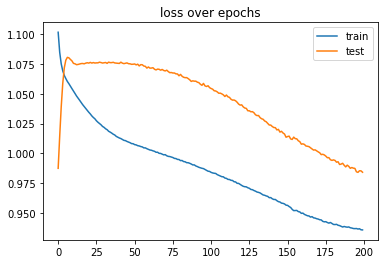

In [99]:
epochs = range(len(train_loss))
plt.plot(epochs, train_loss)
plt.plot(epochs, test_loss)
plt.legend(["train", "test"])
plt.title("loss over epochs")

### test predictions

In [100]:
print(batch1_test)
print(batch1_train)

{'label': tensor([2, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 2, 0,
        0, 0, 0, 0, 1, 0, 0, 0]), 'input_ids': tensor([[0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 2, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 2, 1, 1],
        [0, 0, 0,  ..., 1, 0, 1],
        [0, 0, 0,  ..., 2, 1, 1]])}
{'label': tensor([2, 2, 1, 1, 2, 2, 0, 1, 2, 1, 0, 1, 1, 0, 0, 0, 2, 0, 1, 1, 1, 1, 0, 2,
        0, 1, 0, 1, 2, 0, 0, 1]), 'input_ids': tensor([[0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 1, 2],
        [0, 0, 0,  ..., 1, 1, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 2],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 2]])}


In [101]:
# set idx up to batch size (e.g. 32)
# from dataset
analyze_idx = range(0, 32)
predicted_TF_neural = [True]*len(analyze_idx)
for ai in analyze_idx:
  idx = ai
  actual_label = nDS_test['label'][idx]
  #print(pred_text)
  #print(actual_label)
  # predict with trained model
  with torch.no_grad():
    pred_batch_neural = model_neural(batch1_test['input_ids'].to(device))
    # test here 
    predicted_label = np.argmax(pred_batch_neural[idx].cpu())
    print("predicted choice: " + str(predicted_label) + " | actual choice:: " + str(actual_label))
    
    if predicted_label != actual_label:
        predicted_TF_neural[ai] = False

predicted choice: tensor(1) | actual choice:: tensor(2)
predicted choice: tensor(1) | actual choice:: tensor(2)
predicted choice: tensor(0) | actual choice:: tensor(0)
predicted choice: tensor(1) | actual choice:: tensor(0)
predicted choice: tensor(1) | actual choice:: tensor(0)
predicted choice: tensor(0) | actual choice:: tensor(1)
predicted choice: tensor(0) | actual choice:: tensor(0)
predicted choice: tensor(1) | actual choice:: tensor(0)
predicted choice: tensor(0) | actual choice:: tensor(0)
predicted choice: tensor(1) | actual choice:: tensor(2)
predicted choice: tensor(1) | actual choice:: tensor(0)
predicted choice: tensor(1) | actual choice:: tensor(0)
predicted choice: tensor(0) | actual choice:: tensor(0)
predicted choice: tensor(0) | actual choice:: tensor(0)
predicted choice: tensor(1) | actual choice:: tensor(2)
predicted choice: tensor(0) | actual choice:: tensor(0)
predicted choice: tensor(0) | actual choice:: tensor(0)
predicted choice: tensor(0) | actual choice:: te

In [102]:
# initial accuracy
predicted_TF_neural.count(True) / len(analyze_idx)

0.46875

## summary:
- initial results suggest that bins of neural activity spikes construed as tokenized sequences analogous to language modeling is amenable to transformer architecture. 47% initial accuracy vs. 33% expected by chance. Interestingly, this may already outperform RNN and LSTM models (around 30%, as in "DNN_decoding.ipynb") despite a fraction of training data utilized. 

## next steps:
- add more neurons and trials
- experiment with embedding size, architecture, etc.
- consider validation on other sessions of data or types of data
- consider crossvalidation, regularization, adding more data and dimensionality reduction to troubleshoot potential overfitting

## future directions:
- is there a "grammar" structure to neural activity; what representations are transformers "learning" that enables prediction? 
- real-time sequence prediction
  - can compare EEG, single cell electrophysiology, single cell calcium imaging
  - expect improved performance in anomaly detection, e.g. epileptiform activity
- intrabrain, interregional
- interbrain
